In [1]:
using Plots, LinearAlgebra, Statistics, DataFrames, CSV, NLsolve, Memoize, MLJBase, Pkg, MLJModels, ScikitLearn, Flux, Zygote, Statistics, StatsBase, PyCall, Dates, MLJParticleSwarmOptimization, StatisticalMeasures, MLJTuning, Distributions, MethodChains, SIRUS

In [2]:
include("../utils.jl")

evaluate_trading_strat_sbc (generic function with 1 method)

In [3]:
train_tickers = ["AAL", "CPA", "DAL", "UAL", "AAL", "ALK"]
market_tickers = ["^GSPC", "^IXIC", "^VIX", "^RUT", "^DJI"]
start_date = "2000-01-01"
cut_off = "2022-01-01"
window = 14

14

In [4]:
# make_NPMM_data(train_datas[1], 14)
train_datas, test_datas = make_train_test_data(train_tickers, market_tickers, start_date, cut_off)
train_NPMM_labeled_merged = concat_training_datas(train_datas, window)
sort!(train_NPMM_labeled_merged, :Date) 
full_train_X_df = DataFrames.select(train_NPMM_labeled_merged, Not([:Date, :target]))
full_train_X = (full_train_X_df |> Matrix)
full_train_Y = train_NPMM_labeled_merged[:, :target] |> Vector;

In [5]:
EvoTreeClassifier = @load EvoTreeClassifier pkg="EvoTrees"

import EvoTrees

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\bhatn\.julia\packages\MLJModels\L1gIK\src\loading.jl:159


 ✔


EvoTrees.EvoTreeClassifier

In [6]:
evotree = EvoTreeClassifier()
r1 = (MLJTuning.range(evotree, :max_depth, values = 3:7))
r2 = (MLJTuning.range(evotree, :colsample, lower=0.0, upper=1.0), Uniform)
r3 = (range(evotree, :eta, lower = 0.0, upper = 1.0), Uniform)
r4 = (range(evotree, :nrounds, values = 10:30))
r5 = (range(evotree, :L2, lower = 0.0, upper = 10.0), Uniform)
r6 = (range(evotree, :lambda, lower = 0.0, upper = 10.0), Uniform)
r7 = (range(evotree, :gamma, lower = 0.0, upper = 10.0), Uniform)
r8 = (range(evotree, :min_weight, values = 1:5))
r9 = (range(evotree, :rowsample, lower=0.0, upper=1.0), Uniform)
r10 = (range(evotree, :nbins, values = 2:255))
r11 = (range(evotree, :tree_type, values = ["binary", "oblivious"]))
r12 = (range(evotree, :alpha, lower = 0.0, upper = 1.0), Uniform)
# r12 = (range(evotree, :loss, values = [:logistic]))
# r11 = (range(evotree, :scitype_check_level, values = 0))
self_tuning_evotree = MLJTuning.TunedModel(
    model = evotree,
    resampling = TimeSeriesCV(nfolds=5),
    tuning = AdaptiveParticleSwarm(n_particles=3),#Grid(resolution=10, shuffle=true, rng=1234),
    range = [r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12],
    # measure = (yh, y) -> StatisticalMeasures.accuracy(mode.(yh), y),
    measure = [MLJBase.BrierLoss(), (yh, y) -> StatisticalMeasures.accuracy(mode.(yh), y)],
    acceleration = CPUThreads(),
    n = 50,
    # scitype_check_level=0
)
mach = machine(self_tuning_evotree, full_train_X, full_train_Y .|> Int64)
MLJBase.fit!(mach,  verbosity=0)
# test_X, test_Y = make_NPMM_data(test_datas[1], window) |> make_matrices
# StatisticalMeasures.accuracy(mode.(MLJBase.predict(mach, test_X)), test_Y .|> Int64)
# evaluate_trading_strat(mach, test_datas[1], .5, :)
report(mach)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc MLJTuning.ProbabilisticTunedModel` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}},

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

(best_model = EvoTrees.EvoTreeClassifier{EvoTrees.MLogLoss}
 - nrounds: 11
 - L2: 4.261860691458191
 - lambda: 0.0
 - gamma: 2.031649318620983
 - eta: 0.2750900648520798
 - max_depth: 3
 - min_weight: 4.0
 - rowsample: 0.5124587078826912
 - colsample: 0.985017419646272
 - nbins: 169
 - alpha: 0.6617964303118633
 - tree_type: oblivious
 - rng: Random.MersenneTwister(123, (0, 71104, 69650, 860))
,
 best_history_entry = (model = EvoTrees.EvoTreeClassifier{EvoTrees.MLogLoss}
 - nrounds: 11
 - L2: 4.261860691458191
 - lambda: 0.0
 - gamma: 2.031649318620983
 - eta: 0.2750900648520798
 - max_depth: 3
 - min_weight: 4.0
 - rowsample: 0.5124587078826912
 - colsample: 0.985017419646272
 - nbins: 169
 - alpha: 0.6617964303118633
 - tree_type: oblivious
 - rng: Random.MersenneTwister(123, (0, 71104, 69650, 860))
,
                       measure = Any[BrierLoss(), var"#41#42"()],
                       measurement = AbstractFloat[0.15060343f0, 0.9143801652892563],
                       per_fold =

In [23]:
eval_dicts = [Dict(evaluate_trading_strat(mach, test_data, .8, :)...) for test_data in test_datas]
alltrades = reduce(vcat, [eval_dict[:trade_vals] for eval_dict in eval_dicts])
rr = [eval_dict[:return_rate] for eval_dict in eval_dicts]
arr = [eval_dict[:algo_return_rate] for eval_dict in eval_dicts]
mean_return_rate = mean(rr)
std_return_rate = std(rr)
mean_algo_return_rate = mean(arr)
std_algo_return_rate = std(arr)
[
:win_rate => mean(alltrades .> 0),
:mean_val => mean(alltrades),
:std_val => std(alltrades),
:mean_win => mean(alltrades[alltrades .> 0]),
:mean_loss => mean(alltrades[alltrades .< 0]),
:mean_algo_return_rate => mean_algo_return_rate,
:std_algo_return_rate => std_algo_return_rate,
:mean_return_rate => mean_return_rate,
:std_return_rate => std_return_rate,
]

9-element Vector{Pair{Symbol, Float64}}:
              :win_rate => 0.6756756756756757
              :mean_val => -0.044351180824073584
               :std_val => 2.0070598132401054
              :mean_win => 0.7747601394653321
             :mean_loss => -1.7957262544550447
 :mean_algo_return_rate => -0.08969293236225541
  :std_algo_return_rate => 0.13116844566747246
      :mean_return_rate => -0.20084404688704716
       :std_return_rate => 0.11876752156521782

In [24]:
[(ticker, evaluate_trading_strat(mach, test_data, .8, :)[1:8]) for (test_data, ticker) in zip(test_datas, train_tickers)]

6-element Vector{Tuple{String, Vector{Pair{Symbol, Any}}}}:
 ("AAL", [:win_rate => 0.6333333333333333, :mean_val => -0.03083337148030599, :std_val => 0.7996383190767979, :mean_win => 0.4063158286245246, :mean_loss => -0.8233335131690616, :algo_return => -1.8500022888183594, :algo_return_rate => -0.09866678873697916, :asset_return => -6.029999732971191])
 ("CPA", [:win_rate => 0.803030303030303, :mean_val => 0.1309098330411044, :std_val => 3.1578882166376565, :mean_win => 1.202830692507186, :mean_loss => -4.239229055551382, :algo_return => 8.64004898071289, :algo_return_rate => 0.10384674636572128, :asset_return => -0.029998779296875])
 ("DAL", [:win_rate => 0.7101449275362319, :mean_val => -0.008550699206366055, :std_val => 1.7099287841426085, :mean_win => 0.6593877052774235, :mean_loss => -1.6449997901916504, :algo_return => -0.5899982452392578, :algo_return_rate => -0.014643788330416211, :asset_return => -7.430000305175781])
 ("UAL", [:win_rate => 0.631578947368421, :mean_val => -0.2

In [41]:
model = StableRulesClassifier(n_trees = 1_000, lambda = 2)
mach_sbc = machine(model, full_train_X_df, full_train_Y)
# MLJBase.fit!(mach_sbc, verbosity=0)
perf_eval = MLJBase.evaluate!(mach_sbc, resampling=TimeSeriesCV(nfolds=5), measure = (yh, y) -> StatisticalMeasures.accuracy(mode.(yh), y), verbosity = 0)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc SIRUS.StableRulesClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{Union{AbstractVector{ScientificTypesBase.Continuous}, AbstractVector{Count}}}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}}}, AbstractVector{<:Finite}}
└ @ MLJBase C:\Us

PerformanceEvaluation object with these fields:
  model, measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows, resampling, repeats
Extract:
┌─────────────────┬───────────┬─────────────┬─────────┬─────────────────────────
│ measure         │ operation │ measurement │ 1.96*SE │ per_fold               ⋯
├─────────────────┼───────────┼─────────────┼─────────┼─────────────────────────
│ var"#107#108"() │ predict   │ 0.8         │ 0.0378  │ [0.808, 0.74, 0.792, 0 ⋯
└─────────────────┴───────────┴─────────────┴─────────┴─────────────────────────
                                                                1 column omitted


In [42]:
perf_eval.per_fold

1-element Vector{Vector{Float64}}:
 [0.8082644628099174, 0.740495867768595, 0.7917355371900826, 0.8462809917355372, 0.8115702479338843]

In [43]:
mach_sbc.fitresult

StableRules model with 7 rules:
 if X[i, :volatility_kcli] < 1.0 then 0.139 else 0.013 +
 if X[i, :momentum_stoch] < 66.666664 then 0.002 else 0.014 +
 if X[i, :momentum_stoch_rsi] < 0.6425483 then 0.004 else 0.015 +
 if X[i, :momentum_wr] < -51.76471 then 0.001 else 0.004 +
 if X[i, :others_dr] < 0.3911308 then 0.001 else 0.004 +
 if X[i, :volatility_kchi] < 1.0 then 0.008 else 0.034 +
 if X[i, :volatility_kcp] < 0.7508161 then 0.002 else 0.009
and 2 classes: Real[0, 1]. 
Note: showing only the probability for class 1 since class 0 has probability 1 - p.


In [44]:
mean(predict_mode(mach_sbc, full_train_X_df) .== (full_train_Y .|> Int64))

0.772852422907489

In [45]:
eval_dicts = [Dict(evaluate_trading_strat_sbc(mach_sbc, test_data, .8, :)...) for test_data in test_datas]
alltrades = reduce(vcat, [eval_dict[:trade_vals] for eval_dict in eval_dicts])
rr = [eval_dict[:return_rate] for eval_dict in eval_dicts]
arr = [eval_dict[:algo_return_rate] for eval_dict in eval_dicts]
mean_return_rate = mean(rr)
std_return_rate = std(rr)
mean_algo_return_rate = mean(arr)
std_algo_return_rate = std(arr)
[
:win_rate => mean(alltrades .> 0),
:mean_val => mean(alltrades),
:std_val => std(alltrades),
:mean_win => mean(alltrades[alltrades .> 0]),
:mean_loss => mean( alltrades[alltrades .< 0]),
:mean_algo_return_rate => mean_algo_return_rate,
:std_algo_return_rate => std_algo_return_rate,
:mean_return_rate => mean_return_rate,
:std_return_rate => std_return_rate,
]

9-element Vector{Pair{Symbol, Float64}}:
              :win_rate => 0.5977653631284916
              :mean_val => -0.13033507789313462
               :std_val => 2.613553590858772
              :mean_win => 1.0794395731988353
             :mean_loss => -1.9553522996499504
 :mean_algo_return_rate => -0.1360958640555856
  :std_algo_return_rate => 0.11490999718944442
      :mean_return_rate => -0.20084404688704716
       :std_return_rate => 0.11876752156521782

In [37]:
report(mach).best_history_entry.per_fold

2-element Vector{Vector}:
 Float32[0.17506036, 0.15477265, 0.15945086, 0.14292951, 0.13892375]
 Any[0.9008264462809917, 0.9173553719008265, 0.9090909090909091, 0.9190082644628099, 0.9190082644628099]

In [38]:
test_X, test_Y = make_matrices(concat_training_datas(test_datas, window))
mean(predict_mode(mach, test_X) .== (test_Y .|> Int64))

0.9656862745098039

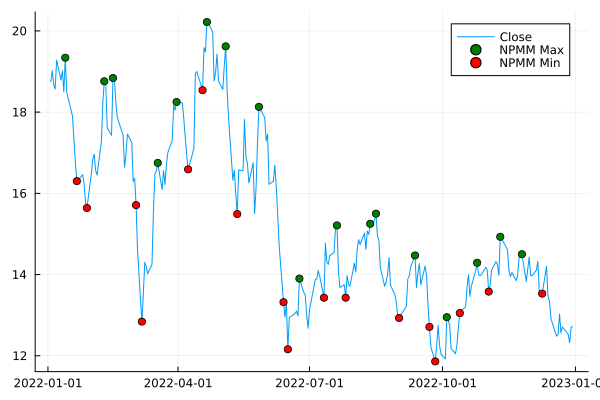

In [39]:
targets = NPMM(test_datas[1], 14)
plot(test_datas[1].Date, test_datas[1].Close, label="Close")
scatter!(test_datas[1].Date[targets .== 1], test_datas[1].Close[targets .== 1], label="NPMM Max", color = :green)
scatter!(test_datas[1].Date[targets .== 0], test_datas[1].Close[targets .== 0], label="NPMM Min", color = :red)

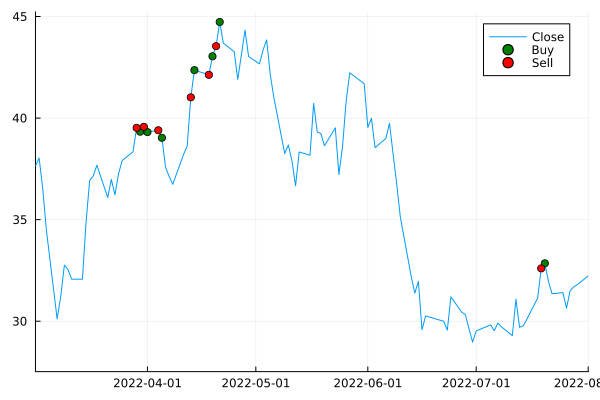

In [40]:
i = 3
buys, sells = zip(eval_dicts[i][:trades]...) .|> collect
plot(test_datas[i].Date, test_datas[i].Close, label="Close")
scatter!(test_datas[i].Date[buys], test_datas[i].Close[buys], label="Buy", color=:green)
scatter!(test_datas[i].Date[sells], test_datas[i].Close[sells], label="Sell", color=:red)
plot!(xlim = (Date(2022, 3, 1), Date(2022, 8, 1)))